In [1]:
!pip install keras-tuner

^C
ERROR: Operation cancelled by user


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD
from keras.layers import Input, Lambda, Dense, Flatten
import tensorflow as tf

In [4]:
picture_size = 48
folder_path = "/kaggle/input/emotion-detection-fer"

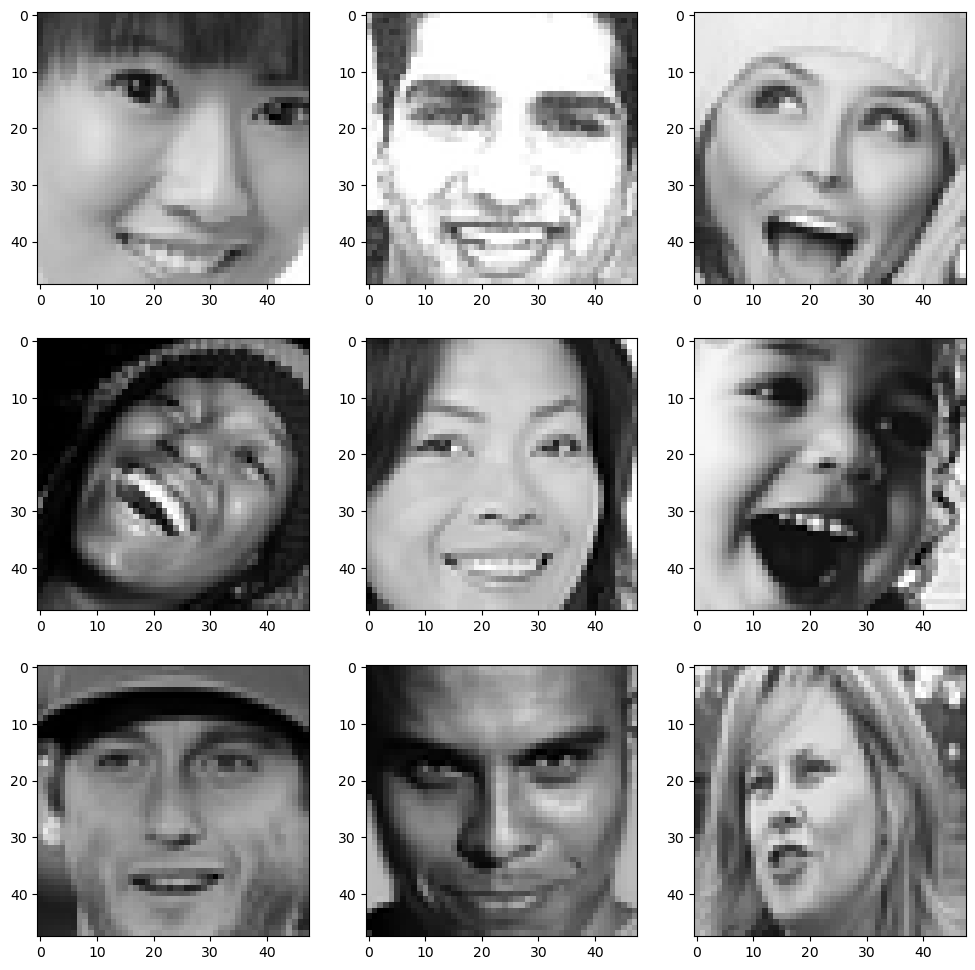

In [5]:
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"/train/"+expression+"/"+
                  os.listdir(folder_path + "/train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [8]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   color_mode="grayscale",
                                                   subset = 'training',
                                                   batch_size = 128)

valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode="grayscale",
                                                  subset = 'validation',
                                                  batch_size = 128)

test_dataset = test_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/test',
                                                  target_size = (48,48),
                                                  color_mode="grayscale",
                                                  class_mode = 'categorical',
                                                  batch_size = 128)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [10]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CNN model

In [11]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(128,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

In [12]:
x_test,y_test =next(test_dataset)
x_test.shape

(128, 48, 48, 1)

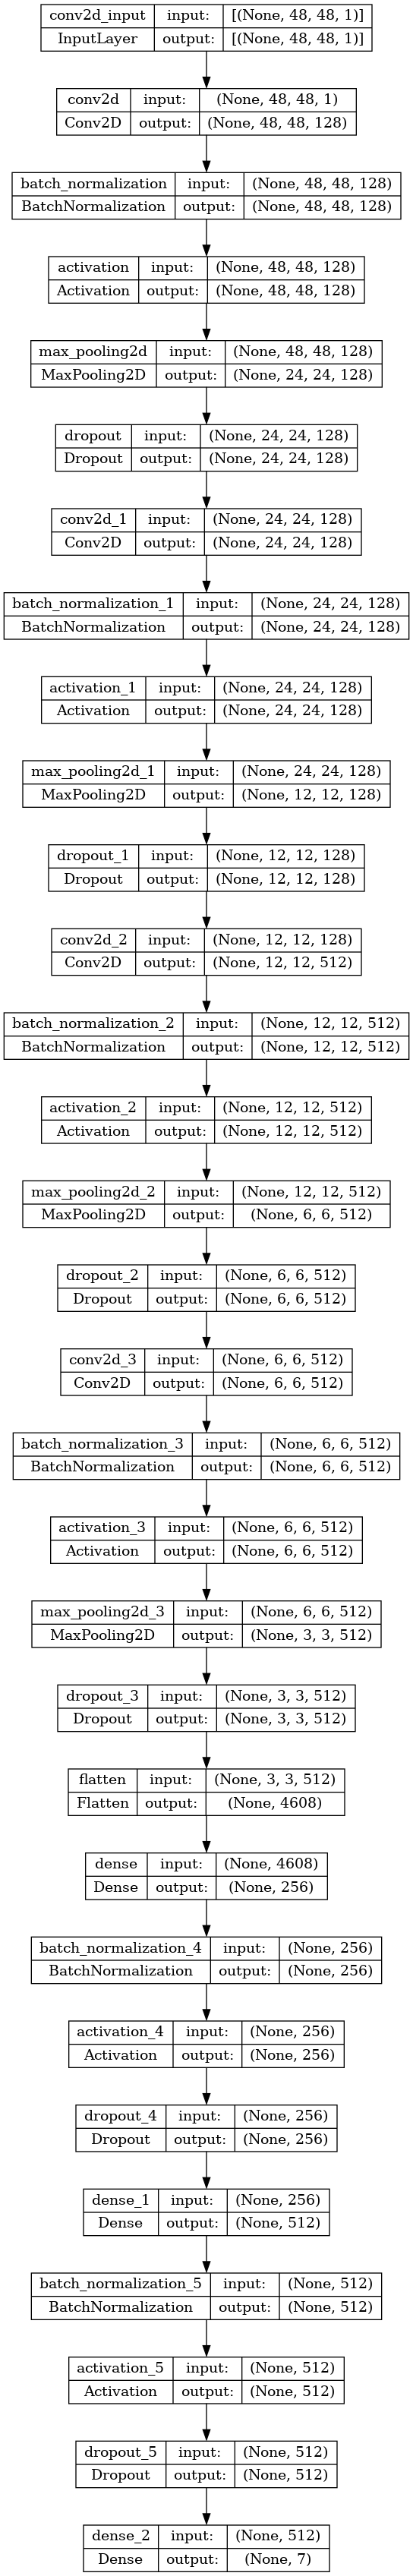

In [13]:
tf.keras.utils.plot_model(model, "cnn.png", show_shapes=True)


In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as K

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('cnn.h5')

es = EarlyStopping(verbose=1, patience=20)

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
opt = Adam(lr = 0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       4

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history=model.fit(
    train_dataset,
    epochs=150,
    validation_data=valid_dataset,
    verbose = 1,callbacks=[lrd,mcp,es]
)


Epoch 1/150


2023-05-03 13:54:49.793305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


180/180 [==============================] - 96s 476ms/step - loss: 1.9519 - accuracy: 0.8498 - precision: 0.2214 - recall: 0.0206 - auc: 0.6309 - f1_score: 0.0365 - val_loss: 1.8476 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6491 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/150
180/180 [==============================] - 34s 187ms/step - loss: 1.8504 - accuracy: 0.8547 - precision: 0.2683 - recall: 0.0101 - auc: 0.6531 - f1_score: 0.0193 - val_loss: 1.8688 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6481 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/150
180/180 [==============================] - 33s 183ms/step - loss: 1.8003 - accuracy: 0.8553 - precision: 0.3716 - recall: 0.0190 - auc: 0.6760 - f1_score: 0.0356 - val_loss: 1.7921 - val_accuracy: 0.8574 - val_precision: 0.6452 - val_recall: 0.0035 - val_auc: 0.6757 - val_f1_score: 0.0069 - lr: 0.0010
Epoch 4/150
180/180 [======================

In [17]:
model.save('./cnn.h5')

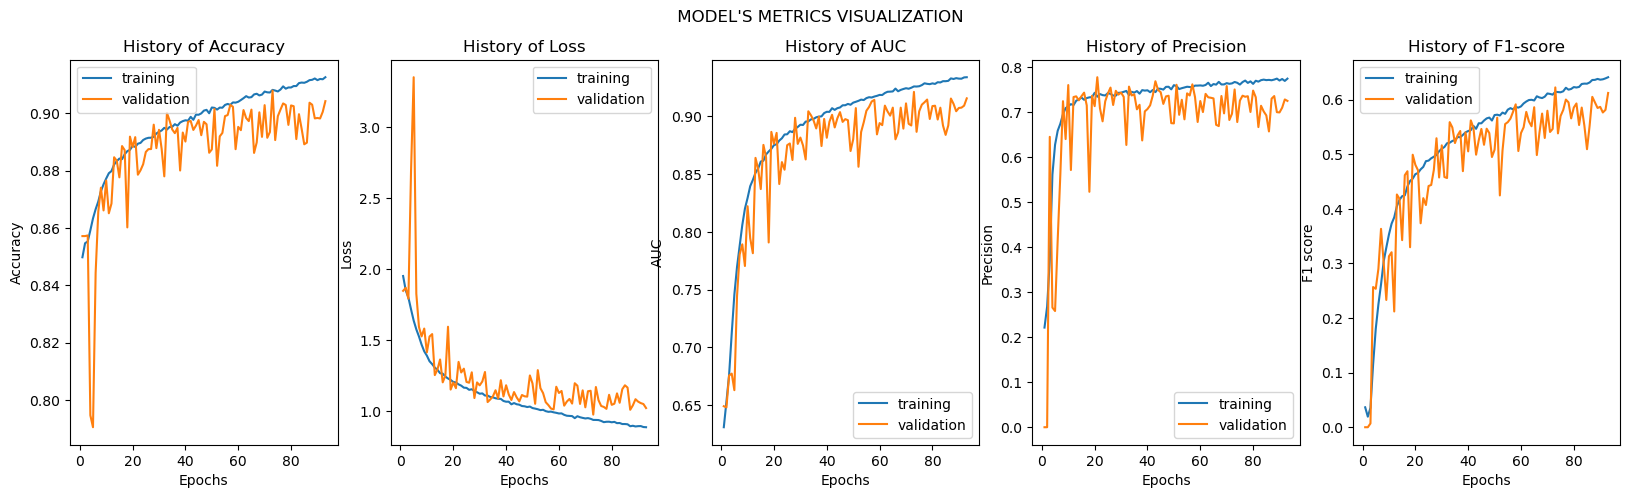

In [18]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )


In [20]:
accuracy = model.evaluate(x_test, y_test)
# Extract the overall accuracy
overall_accuracy = accuracy[1]

# Print the overall accuracy
print("Overall test accuracy:", overall_accuracy)

4/4 [==============================] - 0s 10ms/step - loss: 1.0946 - accuracy: 0.9051 - precision: 0.7363 - recall: 0.5234 - auc: 0.9083 - f1_score: 0.6114
Overall test accuracy: 0.9051339030265808


# Vgg16

In [21]:
from keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,Activation
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import tensorflow as tf

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [23]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
(x_train_data,y_train_data) = next(train_dataset) 
(x_test_data,y_test_data) = next(train_dataset) 

In [25]:
import tensorflow as tf
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 3s 0us/step


In [26]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [27]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))



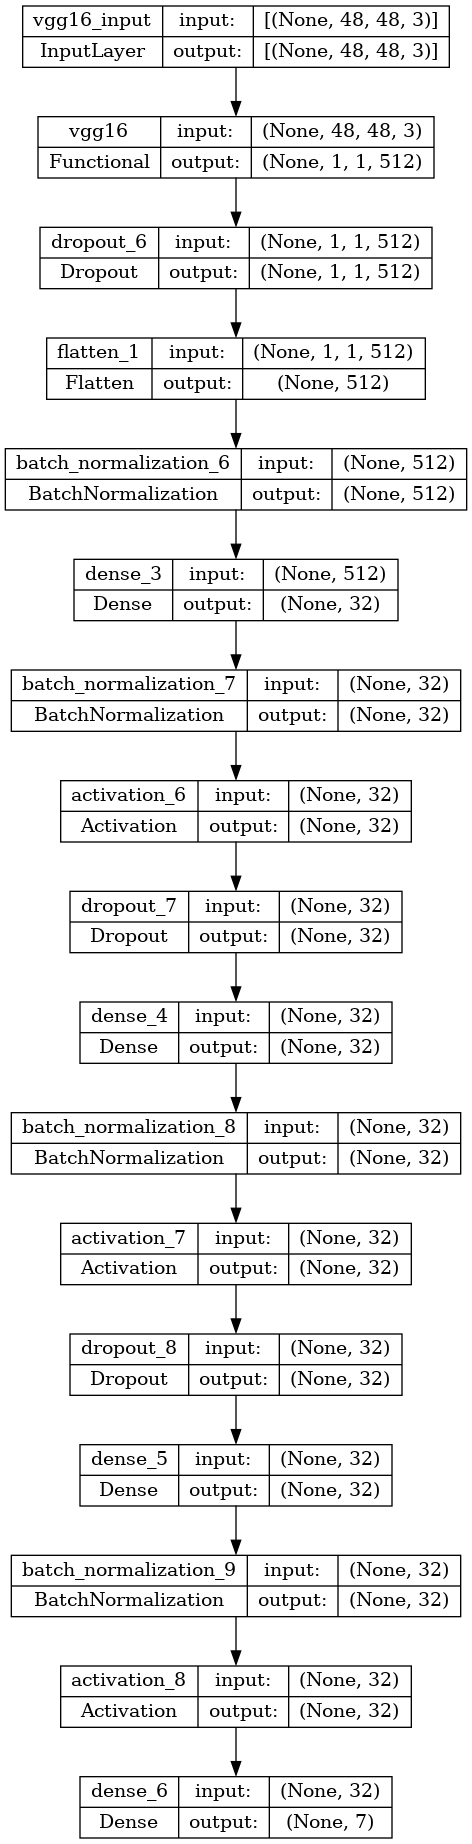

In [28]:
tf.keras.utils.plot_model(model, "Custom_vgg16.png", show_shapes=True)


In [29]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as K

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('vgg16.h5')

es = EarlyStopping(verbose=1, patience=20)

In [32]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)


In [34]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 150,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/150
359/359 [==============================] - 48s 133ms/step - loss: 1.8353 - accuracy: 0.8571 - precision: 0.3448 - recall: 4.3539e-04 - auc: 0.6336 - f1_score: 8.5448e-04 - val_loss: 1.8117 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6505 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/150
359/359 [==============================] - 47s 132ms/step - loss: 1.7997 - accuracy: 0.8570 - precision: 0.4222 - recall: 0.0025 - auc: 0.6592 - f1_score: 0.0048 - val_loss: 3.5846 - val_accuracy: 0.7611 - val_precision: 0.1220 - val_recall: 0.1085 - val_auc: 0.5673 - val_f1_score: 0.1151 - lr: 0.0010
Epoch 3/150
359/359 [==============================] - 47s 130ms/step - loss: 1.7777 - accuracy: 0.8570 - precision: 0.4667 - recall: 0.0061 - auc: 0.6740 - f1_score: 0.0118 - val_loss: 1.8439 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6422 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/150
359/359 [==

In [36]:
model.save('./vgg16.h5')

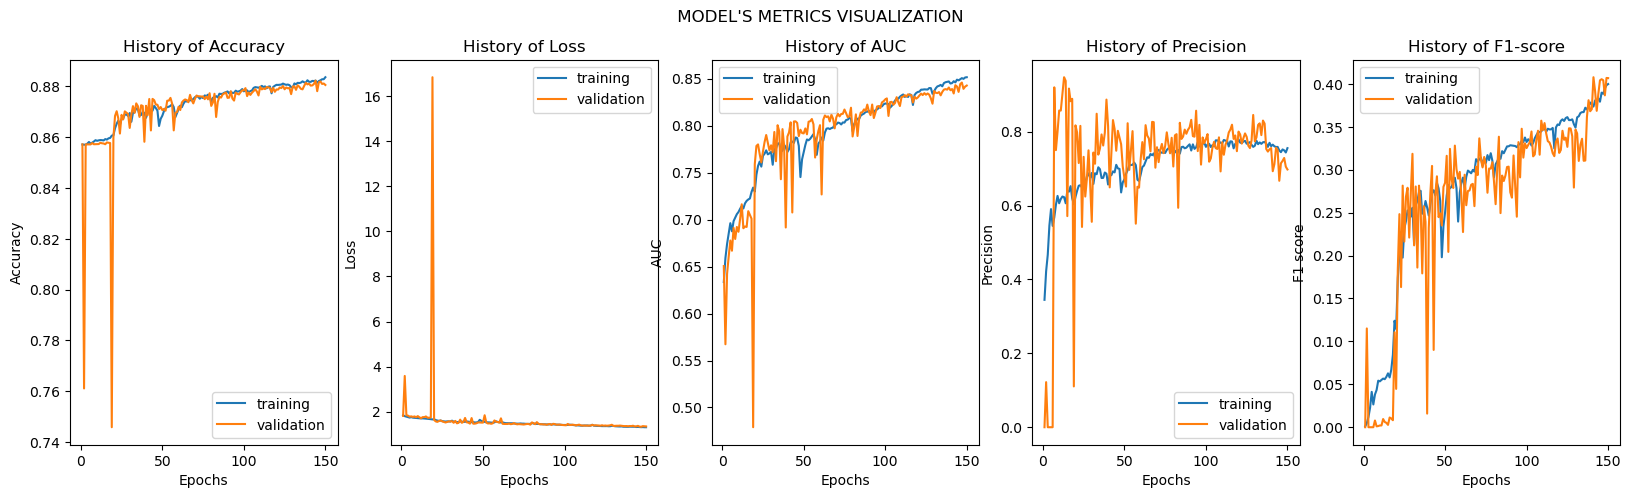

In [37]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )


In [38]:
accuracy = model.evaluate(x_test_data, y_test_data)
# Extract the overall accuracy
overall_accuracy = accuracy[1]

# Print the overall accuracy
print("Overall test accuracy:", overall_accuracy)

2/2 [==============================] - 0s 20ms/step - loss: 1.2056 - accuracy: 0.8973 - precision: 0.8750 - recall: 0.3281 - auc: 0.8786 - f1_score: 0.4752
Overall test accuracy: 0.8973214030265808


# **Hybrid model**

In [39]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Dropout
import os
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [40]:
"""
## Method - II (Using DataGenerator)

from keras.preprocessing.image import ImageDataGenerator

# Define batch size
batch_size = 64

# Create data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load training data in batches
train_generator = datagen.flow_from_directory(
    '/kaggle/input/emotion-detection-fer/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Load validation data in batches
validation_generator = datagen.flow_from_directory(
    '/kaggle/input/emotion-detection-fer/test',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)
# Defining Image size
SIZE = 48
"""

"\n## Method - II (Using DataGenerator)\n\nfrom keras.preprocessing.image import ImageDataGenerator\n\n# Define batch size\nbatch_size = 64\n\n# Create data generator\ndatagen = ImageDataGenerator(rescale=1./255)\n\n# Load training data in batches\ntrain_generator = datagen.flow_from_directory(\n    '/kaggle/input/emotion-detection-fer/train',\n    target_size=(224, 224),\n    color_mode='rgb',\n    batch_size=batch_size,\n    class_mode='categorical',\n    shuffle=True)\n\n# Load validation data in batches\nvalidation_generator = datagen.flow_from_directory(\n    '/kaggle/input/emotion-detection-fer/test',\n    target_size=(224, 224),\n    color_mode='rgb',\n    batch_size=batch_size,\n    class_mode='categorical',\n    shuffle=True)\n# Defining Image size\nSIZE = 48\n"

In [41]:
print(os.listdir("/kaggle/input/emotion-detection-fer"))

SIZE = 48 

['test', 'train']


In [42]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [43]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = '/kaggle/input/emotion-detection-fer/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [44]:
(x_train_data,y_train_data) = next(train_dataset) 
(x_test_data,y_test_data) = next(test_dataset) 

In [45]:
resnet_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [46]:
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [47]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [48]:
for layer in resnet_model.layers:
    layer.trainable = False

In [49]:
# Create input layer
input_layer = Input(shape=(48, 48, 3))

# Use the VGG16 model to extract features from the input layer
vgg16_features = vgg16_model(input_layer)

# Use the ResNet50 model to extract features from the input layer
resnet50_features = resnet_model(input_layer)

# Flatten the output from the VGG16 model
vgg16_flatten = Flatten()(vgg16_features)

# Flatten the output from the ResNet50 model
resnet50_flatten = Flatten()(resnet50_features)

# Concatenate the flattened outputs
concatenated_features = tf.keras.layers.concatenate([vgg16_flatten, resnet50_flatten])

# Add a dense layer with 512 neurons and ReLU activation
dense_layer = Dense(512, activation='relu')(concatenated_features)
dense_layer = BatchNormalization()(dense_layer)
# dropout_layer = Dropout(0.25)(dense_layer)

# Add a dense layer with 256 neurons and ReLU activation
dense_layer_1 = Dense(256, activation='relu')(dense_layer)
dense_layer_1 = BatchNormalization()(dense_layer_1)
# dropout_layer_1 = Dropout(0.25)(dense_layer_1)

# Add a dense layer with 256 neurons and ReLU activation
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_2 = BatchNormalization()(dense_layer_2)
# dropout_layer_2 = Dropout(0.25)(dense_layer_2)

# Add a dense layer with 128 neurons and ReLU activation
dense_layer_3 = Dense(128, activation='relu')(dense_layer_2)
dense_layer_3 = BatchNormalization()(dense_layer_3)
# dropout_layer_3 = Dropout(0.25)(dense_layer_3)

# Add a final dense layer with softmax activation for classification
output_layer = Dense(7, activation='softmax')(dense_layer_3)

# Instantiate the model
model = Model(inputs=input_layer, outputs=output_layer)


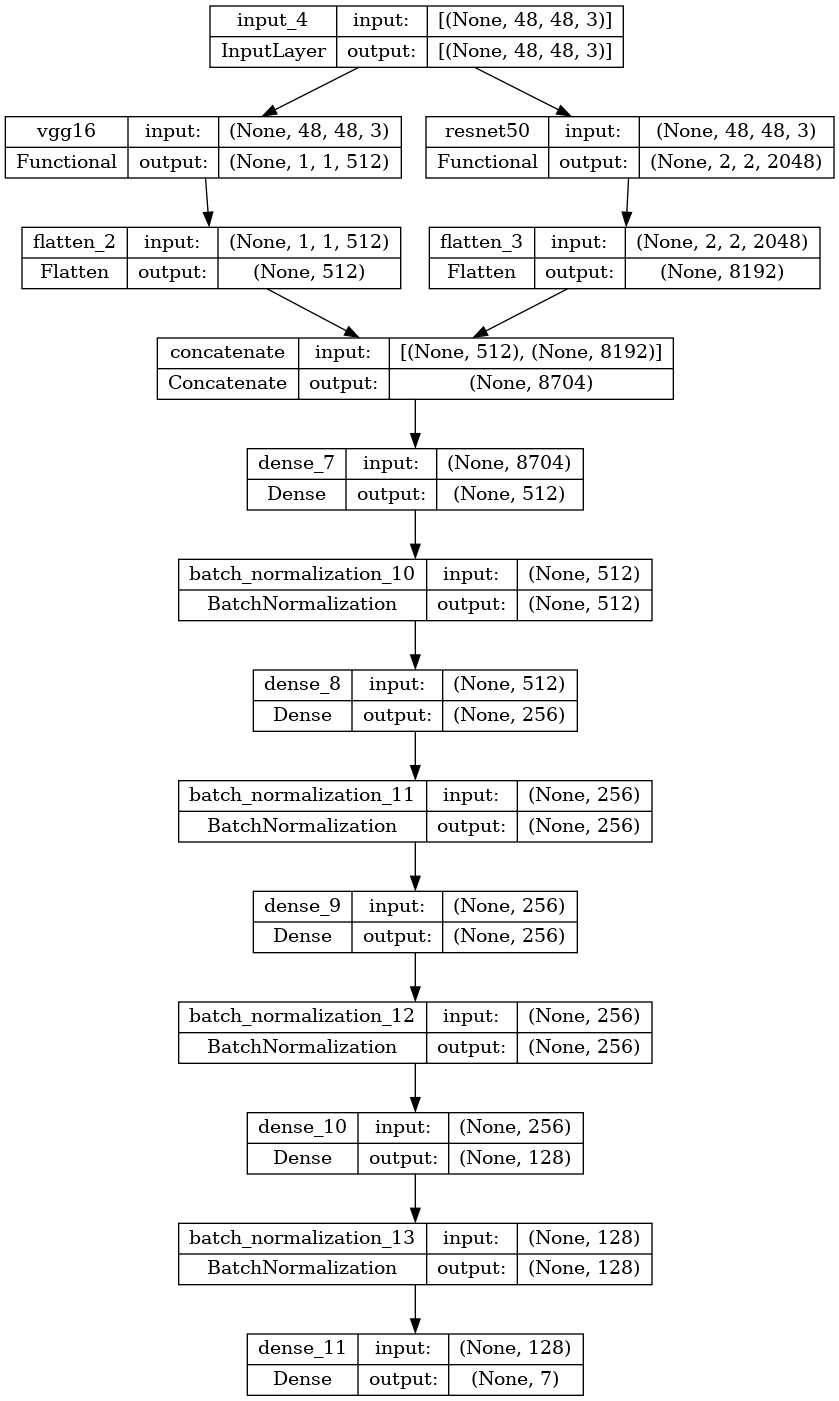

In [50]:
tf.keras.utils.plot_model(model, "hybrid.png", show_shapes=True)


In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 1, 1, 512)    14714688    ['input_4[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 2, 2, 2048)   23587712    ['input_4[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 512)          0           ['vgg16[0][0]']                  
                                                                                              

In [52]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [53]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


In [54]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as K

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('hybrid.h5')

es = EarlyStopping(verbose=1, patience=20)

In [55]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)


In [56]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 150,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/150
359/359 [==============================] - 55s 133ms/step - loss: 1.8164 - accuracy: 0.8556 - precision: 0.4487 - recall: 0.0467 - auc: 0.6790 - f1_score: 0.0832 - val_loss: 1.9303 - val_accuracy: 0.8374 - val_precision: 0.3308 - val_recall: 0.1350 - val_auc: 0.6875 - val_f1_score: 0.1900 - lr: 0.0010
Epoch 2/150
359/359 [==============================] - 46s 128ms/step - loss: 1.6864 - accuracy: 0.8592 - precision: 0.5635 - recall: 0.0631 - auc: 0.7264 - f1_score: 0.1125 - val_loss: 1.8203 - val_accuracy: 0.8551 - val_precision: 0.4631 - val_recall: 0.0918 - val_auc: 0.6920 - val_f1_score: 0.1520 - lr: 0.0010
Epoch 3/150
359/359 [==============================] - 46s 127ms/step - loss: 1.6636 - accuracy: 0.8599 - precision: 0.5769 - recall: 0.0737 - auc: 0.7369 - f1_score: 0.1295 - val_loss: 1.9990 - val_accuracy: 0.8267 - val_precision: 0.3427 - val_recall: 0.2320 - val_auc: 0.7175 - val_f1_score: 0.2764 - lr: 0.0010
Epoch 4/150
359/359 [==============================] - 

In [57]:
model.save('./hybrid.h5')

In [58]:
accuracy = model.evaluate(x_test_data, y_test_data)
# Extract the overall accuracy
overall_accuracy = accuracy[1]

# Print the overall accuracy
print("Overall test accuracy:", overall_accuracy)

2/2 [==============================] - 0s 43ms/step - loss: 1.7247 - accuracy: 0.8415 - precision: 0.3704 - recall: 0.1562 - auc: 0.7632 - f1_score: 0.2109
Overall test accuracy: 0.8415178656578064


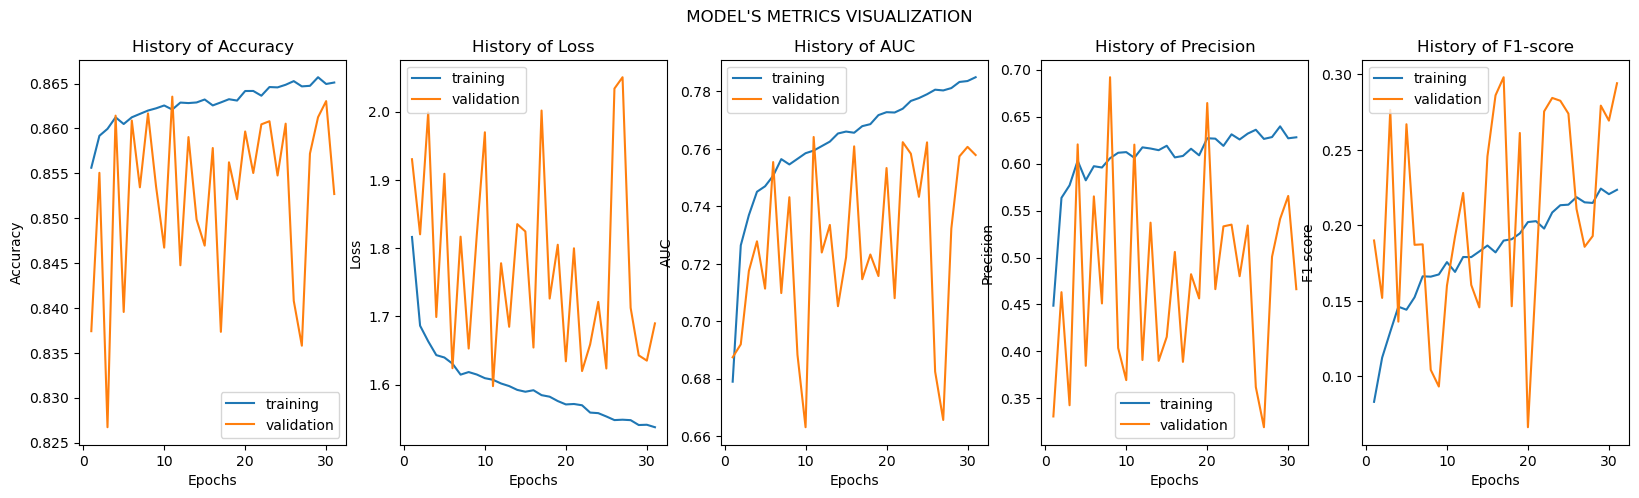

In [59]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )
